In [1]:
from init import *
from utility import *
from repro import readfile

autotime loaded.
black loaded.
black loaded.
time: 1.26 s


<IPython.core.display.Javascript object>

In [2]:
class Reprobus:
    def __init__(self, filename, nbcon=44, ncm=15, islev=np.arange(350, 801, 5)):
        p0, rascp = 1000.0, 2.0 / 7.0
        self.filename = filename
        self.date = pd.to_datetime(filename.split("_")[2], format="%Y%m%d%H")
        if self.date > pd.to_datetime("2019-07-31"):
            self.nlev = 137
        else:
            self.nlev = 60
        nlev = self.nlev
        pj1, uj1, vj1, alt, tj1, qj1, hc = readfile(filename, nlev, nbcon, ncm)
        # print(pj1)
        aa, bb = self.get_coeffs()
        pmb = np.zeros(tj1.shape)
        for i in np.arange(nlev):
            pmb[:, :, i] = aa[i] + bb[i] * pj1
        theta = tj1 * ((p0 / pmb) ** rascp)

        tr1 = {"Ozone": 4, "ClO": 10, "NO2": 6}
        tr2 = {
            "HNO3g": 42,
            "HNO3": 3,
            "N2O": 0,
            "POx": 10,
            "ClONO2": 13,
            "NOx": 20,
            "ClOx": 22,
            "BrOx": 23,
            "HCl": 12,
        }
        self.long_name = {
            "Ozone": "O$_3$",
            "ClO": "ClO",
            "HNO3g": "HNO$_3$ Gas",
            "HNO3": "HNO$_3$",
            "N2O": "N$_2$O",
            "NO2": "NO$_2$",
            "POx": "Passive Ox",
            "ClONO2": "ClONO$_2$",
            "NOx": "NO$_x$",
            "ClOx": "ClO$_x$",
            "BrOx": "BrO$_x$",
            "HCl": "HCl",
        }

        data = xr.Dataset()

        for k, v in tr1.items():
            data[k] = self.isentropic_tracers(hc[:, :, :, v], theta, islev, k)

        for k, v in tr2.items():
            data[k] = self.isentropic_tracers(qj1[:, :, :, v], theta, islev, k)

        self.data = data

    def get_coeffs(self, cdir="."):
        cfile = "%s/ecmwf_%s_levels.txt" % (cdir, self.nlev)
        # print(cfile)
        df = pd.read_csv(cfile, sep="\s+", skiprows=[1])
        df.columns = ["N", "a", "b", "c", "d"]
        aa = 0.01 * df["a"].rolling(1).mean()[1:].values
        bb = df["b"].rolling(1).mean()[1:].values
        # print(df["a"])
        # print(df["b"])
        return aa, bb

    def isentropic_tracers(self, tmp, theta, islev, tr):
        lats = xr.DataArray(
            np.arange(90, -91, -2), dims="Latitude", attrs={"long_name": "Latitude"}
        )
        lons = xr.DataArray(
            np.arange(0, 360, 2), dims="Longitude", attrs={"long_name": "Longitude"}
        )
        levs = np.arange(self.nlev)  # [::-1]

        coords = [lons, lats, levs]
        dims = ["Longitude", "Latitude", "Level"]
        tattrs = {"long_name": "Temperature", "units": "K"}

        theta = xr.DataArray(theta, coords=coords, dims=dims, attrs=tattrs)
        islev = xr.DataArray(islev, dims="Theta", attrs=tattrs)
        tmp = xr.DataArray(tmp / 1e-9, dims=dims, coords=coords)
        tmp = xrvinterp(tmp, theta, islev, "Level", "Theta")
        tmp.attrs = {"long_name": "%s [ppbv]" % self.long_name[tr]}
        return tmp

time: 9.3 ms


<IPython.core.display.Javascript object>

In [3]:
def get_basemap(ax=None, region="north"):
    if not ax:
        fig, ax = facets(1, 1, width=10, aspect=0.6)
        ax = ax[0]

    if region == "north":
        m = Basemap(projection="npstere", lon_0=0, boundinglat=30, round=True, ax=ax)
    else:
        m = Basemap(projection="spstere", lon_0=180, boundinglat=-30, round=True, ax=ax)
    m.drawcoastlines(linewidth=0.35)
    m.drawcountries(linewidth=0.35)
    m.drawmeridians(np.arange(0, 360, 60), labels=[0, 0, 0, 0])
    m.drawparallels(np.arange(20, 80, 20), labels=[1, 1, 0, 0])
    return m


def plot_data(molz, level=475, scale=1, region="north"):
    fig, ax = plt.subplots(1, 1, figsize=(9, 7))
    cax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
    m = get_basemap(ax=ax, region=region)
    data = molz.sel(Theta=level, method="nearest").T.values
    data, lon = addcyclic(data, molz["Longitude"])
    lat, lon = np.meshgrid(molz["Latitude"], lon)
    lon, lat = m(lon, lat)
    im = m.contourf(lon, lat, scale * data.T)
    cb = plt.colorbar(im, cax=cax, orientation="vertical")
    # cb.set_label(label="%s" % (molz.attrs["long_name"]), size=18)
    return fig, ax, cb

time: 2.33 ms


<IPython.core.display.Javascript object>

In [4]:
odir = "/media/pankaj/Data/reprobus/netcdf/"
files = sorted(glob.glob("/media/pankaj/Data/arc2020/*"))
files

['/media/pankaj/Data/arc2020/MODEL_history_2019120112_001434',
 '/media/pankaj/Data/arc2020/MODEL_history_2019120212_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019120312_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019120412_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019120512_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019120612_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019120712_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019120812_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019120912_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121012_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121112_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121212_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121312_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121412_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121512_001435',
 '/media/pankaj/Data/arc2020/MODEL_history_2019121612_0

time: 6.16 ms


<IPython.core.display.Javascript object>

In [5]:
for filename in files:
    print(filename)
    bus = Reprobus(filename)
    ncfile = f"%s%s.nc" % (odir, bus.date.isoformat().split("T")[0])
    print(f"Saving %s" % ncfile)
    bus.data[["Ozone", "POx"]].to_netcdf(ncfile)

/media/pankaj/Data/arc2020/MODEL_history_2019120112_001434
Saving /media/pankaj/Data/reprobus/netcdf/2019-12-01.nc
/media/pankaj/Data/arc2020/MODEL_history_2019120212_001435
Saving /media/pankaj/Data/reprobus/netcdf/2019-12-02.nc
/media/pankaj/Data/arc2020/MODEL_history_2019120312_001435
Saving /media/pankaj/Data/reprobus/netcdf/2019-12-03.nc
/media/pankaj/Data/arc2020/MODEL_history_2019120412_001435
Saving /media/pankaj/Data/reprobus/netcdf/2019-12-04.nc
/media/pankaj/Data/arc2020/MODEL_history_2019120512_001435
Saving /media/pankaj/Data/reprobus/netcdf/2019-12-05.nc
/media/pankaj/Data/arc2020/MODEL_history_2019120612_001435
Saving /media/pankaj/Data/reprobus/netcdf/2019-12-06.nc
/media/pankaj/Data/arc2020/MODEL_history_2019120712_001435
Saving /media/pankaj/Data/reprobus/netcdf/2019-12-07.nc
/media/pankaj/Data/arc2020/MODEL_history_2019120812_001435
Saving /media/pankaj/Data/reprobus/netcdf/2019-12-08.nc
/media/pankaj/Data/arc2020/MODEL_history_2019120912_001435
Saving /media/pankaj/

<IPython.core.display.Javascript object>

In [7]:
bus.data

<xarray.Dataset>
Dimensions:    (Latitude: 91, Longitude: 180, Theta: 91)
Coordinates:
  * Longitude  (Longitude) int64 0 2 4 6 8 10 12 ... 346 348 350 352 354 356 358
  * Latitude   (Latitude) int64 90 88 86 84 82 80 78 ... -80 -82 -84 -86 -88 -90
  * Theta      (Theta) int64 350 355 360 365 370 375 ... 775 780 785 790 795 800
Data variables:
    Ozone      (Longitude, Latitude, Theta) float64 644.6 730.4 ... 4.078e+03
    ClO        (Longitude, Latitude, Theta) float64 4.654e-05 ... 0.1018
    NO2        (Longitude, Latitude, Theta) float64 0.0007323 ... 5.598
    HNO3g      (Longitude, Latitude, Theta) float64 2.294 2.626 ... 5.283 5.168
    HNO3       (Longitude, Latitude, Theta) float64 2.346 2.689 ... 17.52 17.6
    N2O        (Longitude, Latitude, Theta) float64 292.5 287.4 ... 96.14 94.55
    POx        (Longitude, Latitude, Theta) float64 648.9 734.9 ... 4.862e+03
    ClONO2     (Longitude, Latitude, Theta) float64 0.04192 0.05351 ... 0.5053
    NOx        (Longitude, Latitude, Theta) float64 0.001067 0.0009212 ... 11.77
    ClOx       (Longitude, Latitude, Theta) float64 4.654e-05 ... 0.1022
    BrOx       (Longitude, Latitude, Theta) float64 7.081e-06 ... 0.01465
    HCl        (Longitude, Latitude, Theta) float64 0.3887 0.4475 ... 2.252

time: 43.5 ms


<IPython.core.display.Javascript object>

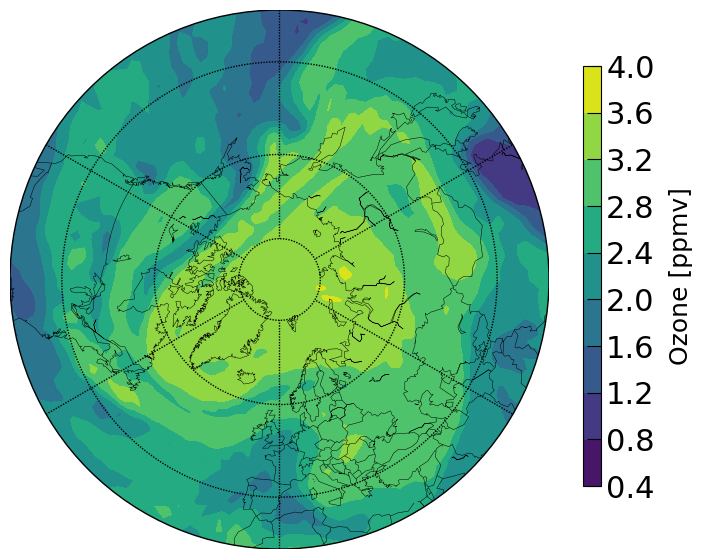

time: 538 ms


<IPython.core.display.Javascript object>

In [8]:
fig, ax, cb = plot_data(bus.data["Ozone"], level=475, scale=0.001, region="north")
cb.set_label(label="%s" % ("Ozone [ppmv]"), size=18)
# plt.savefig("/home/pankaj/Desktop/repro_ozone_435K.png", bbox_inches="tight")
plt.show()